# add some tips

https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

pro 2-2 : noise uni -> normal

pro 2-3 : noise uni -> normal + img size 28 -> 64

pro 2-1 : n-class at mini batch

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

def my_mnist_train_batch(size) :
    m = 500
    data = []
    for i in range(1000) :
        number = number = np.random.randint(5)
        image, label = mnist.train.next_batch(m)       
        for j in range(len(label)) : 
            
            if np.argmax(label[j])==number :
                data.append(image[j])
                number = number = np.random.randint(5)
            if len(data) == size :
                break
        if len(data) == size :
            break
    return np.array(data).reshape(-1,28,28,1)

def my_mnist_test_batch(size, number = 0) :
    m = 500
    data = []
    for i in range(1000) :
        image, label = mnist.test.next_batch(m)       
        for j in range(len(label)) : 
            if np.argmax(label[j])==number :
                data.append(image[j])              
            if len(data) == size :
                break
        if len(data) == size :
            break
    return np.array(data).reshape(-1,28,28,1)

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

file_name = 'proto_2-3'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)
def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse) :
        
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#2048*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#1024*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#512*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#256*32*32

        conv5 = tf.layers.conv2d_transpose(r4,128,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#128*64*64

        conv6 = tf.layers.conv2d_transpose(r5,1,[3,3], strides=(1,1),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.tanh(conv6,name=name)#1*64*64
  

    return r6
def residual_loss_G(x,isTrain = False, reuse = True, name = 'residual_loss_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)    


    with tf.variable_scope('G',reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#2048*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#1024*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#512*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#256*32*32

        conv5 = tf.layers.conv2d_transpose(r4,128,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#128*64*64

        conv6 = tf.layers.conv2d_transpose(r5,1,[3,3], strides=(1,1),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.tanh(conv6,name=name)#1*64*64
  

    return r6
def simple_D(x,isTrain=True,reuse = False) :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,64,64,1)


        conv1 = tf.layers.conv2d(x,128,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#128*32*32

   
        conv2 = tf.layers.conv2d(r1,256,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#256*16*16

  
        conv3 = tf.layers.conv2d(r2,512,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#512*8*8

 
        conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#1024*4*4


        conv5 = tf.layers.conv2d(r4,1,[4,4], strides=(1,1),padding = 'valid',
                                 kernel_initializer=w_init, bias_initializer=b_init)
       
    r5 = tf.nn.sigmoid(conv5)#1*1*1


    return r5
def feature_extractor_D(x,isTrain=False,reuse = True, name='feature_out') :
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D', reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1,28,28,1)

        conv1 = tf.layers.conv2d(x,128,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#128*32*32

   
        conv2 = tf.layers.conv2d(r1,256,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#256*16*16

  
        conv3 = tf.layers.conv2d(r2,512,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
    r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain),name=name)#512*8*8

 
        #conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same',
        #                        kernel_initializer=w_init, bias_initializer=b_init)
        #r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#1024*4*4


        #conv5 = tf.layers.conv2d(r4,1,[4,4], strides=(1,1),padding = 'valid',
       #                         kernel_initializer=w_init, bias_initializer=b_init)
       
  

    return r3



Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
lr = 0.001

z_size = 100

z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 64,64,1),name='u')
ano_y = tf.placeholder(tf.float32, shape = (1, 64,64,1),name='ano_y')

ano_z = tf.get_variable('ano_z', shape = [1, 1, 1, z_size], dtype = tf.float32, 
        initializer = tf.truncated_normal_initializer(mean= 0.0, stddev=0.1))

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 
soft_one = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_one') # 0.9~1.0
soft_zero = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_zero') # 0.0~0.1

G_z = simple_G(z,name='G_z')

D_real = simple_D(u,isTrain)
D_fake = simple_D(G_z,isTrain,reuse=True)


img_z = residual_loss_G(ano_z, name ='img_z')

feature_y = feature_extractor_D(ano_y, reuse = True, name ='feature_y')
feature_z = feature_extractor_D(img_z, reuse = True, name ='feature_z')


feature_loss = tf.reduce_mean(tf.abs(feature_y-feature_z),name = 'feature_loss')
D_real_loss = tf.reduce_mean(-(soft_one*tf.log(D_real + 1e-8) + (1-soft_one)*tf.log(1- D_real + 1e-8)),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-(soft_zero*tf.log(D_fake + 1e-8) + (1-soft_zero)*tf.log(1 - D_fake + 1e-8)),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-tf.log(D_fake + 1e-8),name='G_loss')
residual_loss = tf.reduce_mean(tf.abs(img_z - ano_y), name = 'residual_loss')

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
ano_vars = [var for var in T_vars if var.name.startswith('ano')]
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(G_loss, var_list=G_vars, name='G_optim')
    
residual_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(residual_loss, var_list=ano_vars, name='residual_optim')



D_e : 1.734658, D_real_e : 0.748062, D_fake_e : 0.986597, G_e : 17.217432
D_e : 4.530227, D_real_e : 1.534567, D_fake_e : 3.023616, G_e : 6.946587
D_e : 3.355836, D_real_e : 1.100029, D_fake_e : 1.069672, G_e : 4.511214
D_e : 2.815817, D_real_e : 0.863579, D_fake_e : 0.866801, G_e : 3.654909
D_e : 2.541703, D_real_e : 0.886332, D_fake_e : 0.830286, G_e : 3.224428
D_e : 2.365279, D_real_e : 0.854672, D_fake_e : 0.803149, G_e : 2.934522
D_e : 2.245595, D_real_e : 0.829523, D_fake_e : 0.816456, G_e : 2.747756
D_e : 2.138833, D_real_e : 0.771623, D_fake_e : 0.725570, G_e : 2.630184
D_e : 1.989335, D_real_e : 0.492190, D_fake_e : 0.449163, G_e : 2.667604
D_e : 1.922543, D_real_e : 0.738849, D_fake_e : 0.648692, G_e : 2.675349
D_e : 1.881681, D_real_e : 0.783097, D_fake_e : 0.730416, G_e : 2.665968
D_e : 1.838478, D_real_e : 0.727222, D_fake_e : 0.678796, G_e : 2.652492
D_e : 1.794990, D_real_e : 0.679578, D_fake_e : 0.636609, G_e : 2.637339
D_e : 1.743438, D_real_e : 0.587595, D_fake_e : 0.

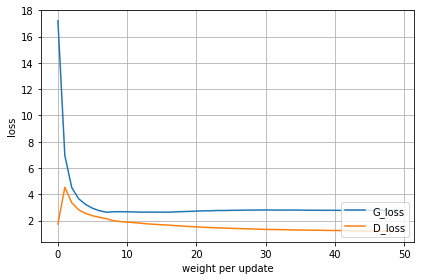

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,z_size))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for i in range(5000) :
        
        train_images = my_mnist_train_batch(100)
        train_images = tf.image.resize_images(train_images,[64,64]).eval()                                                                                                           
        train_images = (train_images -0.5)/0.5 
        
        u_ = np.reshape(train_images,(-1,64,64,1)) 
        z_ = np.random.normal(0,1,size=(100,1,1,z_size))
        soft_one_ = np.random.uniform(0.9,1.0,(100,1,1,1))
        soft_zero_ = np.random.uniform(0.0,0.1,(100,1,1,1))
        
        _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True,
                                                                                         soft_one : soft_one_, soft_zero : soft_zero_})
        D_error.append(D_e)
        D_real_error.append(D_real_e)
        D_fake_error.append(D_fake_e)


    #    train_images,train_labels = mnist.train.next_batch(100)    
    #    u_ = np.reshape(train_images,(-1,28,28,1)) 
    #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
        _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_, isTrain : True}) 
        G_error.append(G_e)
        
        if i%100 == 0:

            hist_D.append(np.mean(D_error)) 
            hist_G.append(np.mean(G_error))

            print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
                np.mean(D_fake_error), np.mean(G_error)))
            log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
                np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
            r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
            mnist_4by4_save(np.reshape(r,(-1,64*64)),file_name + '/result_{}.png'.format(str(i).zfill(3)))

            np.random.seed(int(time.time()))

            G_errer = []
            D_errer = []
            D_fake_error = []
            D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

In [3]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

soft_one = sess.graph.get_tensor_by_name('soft_one:0') # 0.9~1.0
soft_zero = sess.graph.get_tensor_by_name('soft_zero:0') # 0.0~0.1
    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

residual_optim = sess.graph.get_operation_by_name("residual_optim")





INFO:tensorflow:Restoring parameters from proto_2-3/para.cktp


In [4]:
im = my_mnist_test_batch(1, number = 7) 

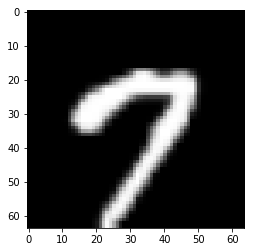

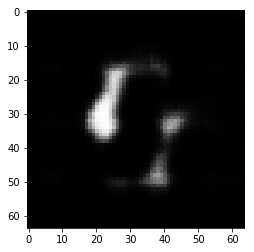

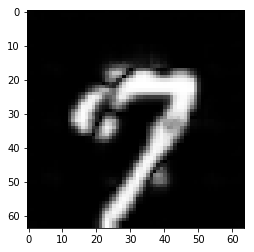

2.68188 0.225014


In [5]:

im = tf.image.resize_images(im,[64,64]).eval()                                                                                                           
im = (im -0.5)/0.5 
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(64, 64)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(64, 64)) - np.reshape(im,(64, 64)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,64, 64,1))})

print(fea_loss, res_loss)

In [6]:
for i in range(1000) :
    _ , loss = sess.run([residual_optim,residual_loss], {ano_y : np.reshape(im,(1,64, 64,1))})
    if  i % 100 == 0 : 
        print(loss)

0.225014
0.127725
0.0934494
0.0767775
0.0663418
0.0608891
0.0572847
0.0547876
0.0529794
0.051659


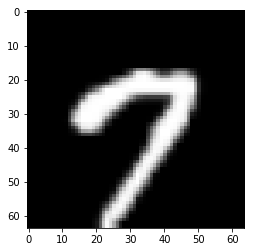

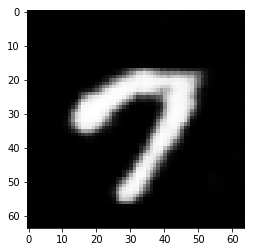

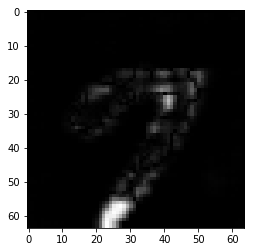

0.848494 0.0506097


In [7]:

plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(64, 64)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(64, 64)) - np.reshape(im,(64, 64)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,64, 64,1))})

print(fea_loss, res_loss)

In [3]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

soft_one = sess.graph.get_tensor_by_name('soft_one:0') # 0.9~1.0
soft_zero = sess.graph.get_tensor_by_name('soft_zero:0') # 0.0~0.1
    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

residual_optim = sess.graph.get_operation_by_name("residual_optim")




INFO:tensorflow:Restoring parameters from proto_2-3/para.cktp


In [4]:
im = my_mnist_test_batch(1, number = 4) 

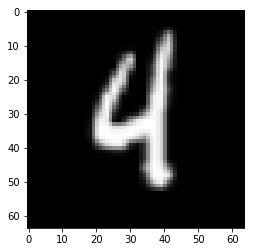

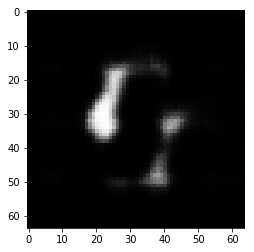

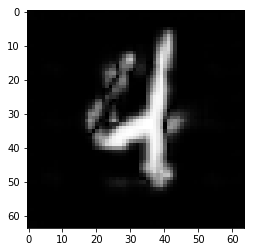

2.0705 0.14799


In [5]:

im = tf.image.resize_images(im,[64,64]).eval()                                                                                                           
im = (im -0.5)/0.5 
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(64, 64)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(64, 64)) - np.reshape(im,(64, 64)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,64, 64,1))})

print(fea_loss, res_loss)

In [6]:
for i in range(1000) :
    _ , loss = sess.run([residual_optim,residual_loss], {ano_y : np.reshape(im,(1,64, 64,1))})
    if  i % 100 == 0 : 
        print(loss)

0.14799
0.0667686
0.0488222
0.0445642
0.0420812
0.0398962
0.0378948
0.0360479
0.0341703
0.0326409


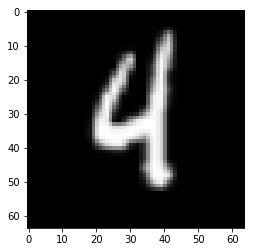

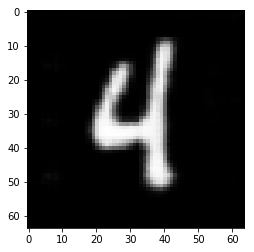

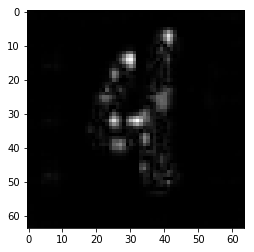

0.696669 0.0312632


In [7]:

plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(64, 64)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(64, 64)) - np.reshape(im,(64, 64)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,64, 64,1))})

print(fea_loss, res_loss)

In [ ]:

#mnist.train.images.shape

In [ ]:
#train_images.reshape(-1,28,28).shape

In [ ]:
#tf.image.resize_images(np.reshape(train_images,(-1,28,28,1)),[64,64]).shape

In [ ]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("../MNIST_data", one_hot=True,reshape = [])